In [1]:
%config InlineBackend.figure_format = 'retina'

# leaderboard

In [2]:
%run -n main
records = parse_tsv(LEADERBOARD_LINES)
leaderboard = list(parse_leaderboard(records))

# jiant

In [3]:
%run -n main.py
grid_task_scores = []
for conf in JIANT_GRID_CONFS:
    for task in TASKS:
        path = join(JIANT_EVAL_DIR, GRID, conf.id, task + JSON)
        if not exists(path):
            # skip rucos, skip some gpt large
            continue

        data = load_json(path)
        score = metrics_score(task, data)

        grid_task_scores.append([conf.id, task, score])

In [4]:
%run -n main.py
task_train_sizes = {
    _: sum(1 for _ in load_task(_, PUBLIC, TRAIN))
    for _ in TASKS
    if _ != LIDIRUS
}

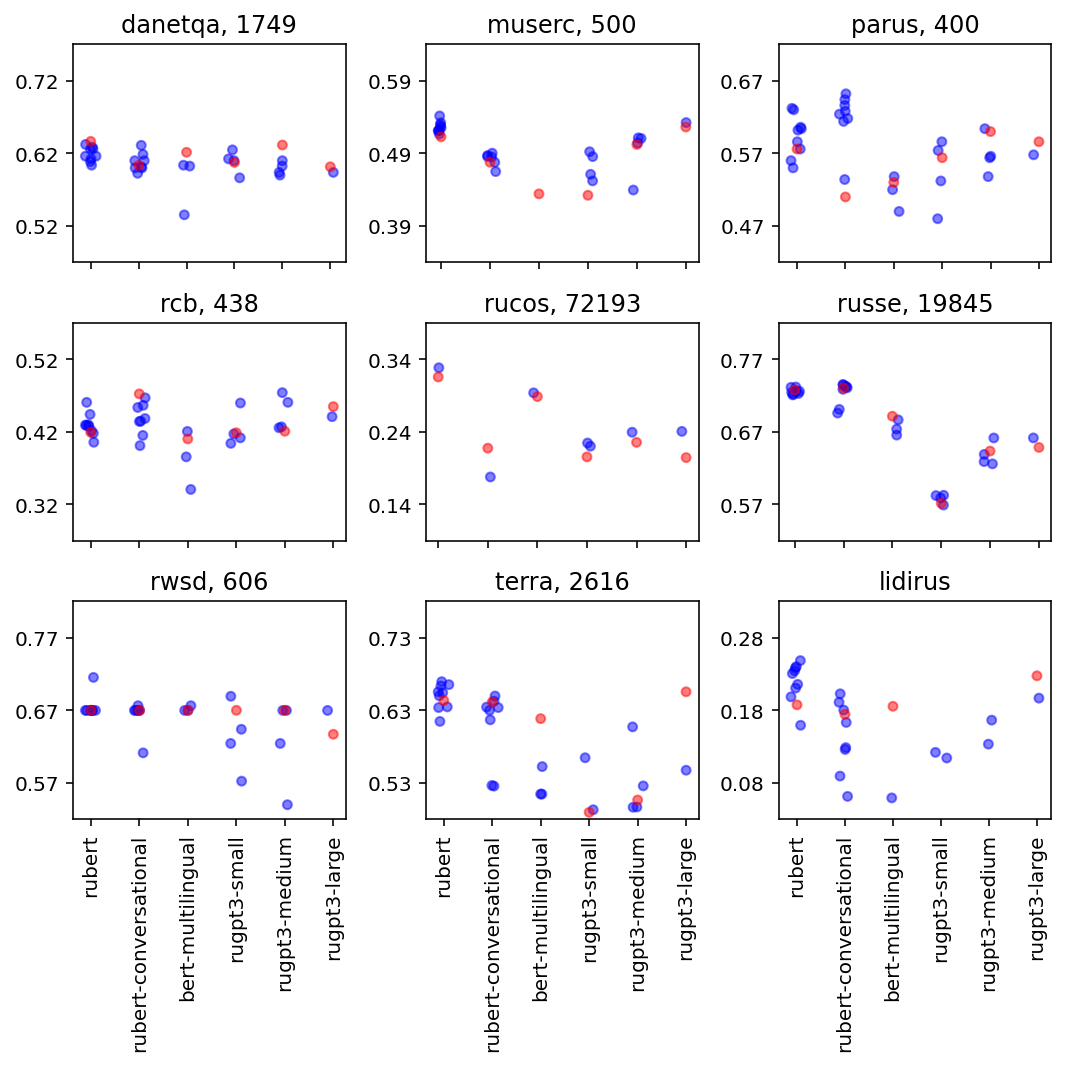

In [5]:
%run -n main
show_grid_scores(leaderboard, grid_task_scores, task_train_sizes)

In [6]:
%run -n main
for model in MODELS:
    for task in TASKS:
        if task == LIDIRUS:
            continue

        id = select_top_conf(task, model, grid_task_scores)
        leaderboard_score = score_value(find_leaderboard_score(model, task, leaderboard))
        grid_score = score_value(find_grid_score(id, task, grid_task_scores))
        label = '!' if grid_score < leaderboard_score else ' '

        print(f'{label} exps/{id}/{task} -> exps/{model}/{task}')

! exps/05/danetqa -> exps/rubert/danetqa
  exps/09/muserc -> exps/rubert/muserc
  exps/06/parus -> exps/rubert/parus
  exps/04/rcb -> exps/rubert/rcb
  exps/04/rucos -> exps/rubert/rucos
  exps/08/russe -> exps/rubert/russe
  exps/04/rwsd -> exps/rubert/rwsd
  exps/04/terra -> exps/rubert/terra
  exps/03/danetqa -> exps/rubert-conversational/danetqa
  exps/13/muserc -> exps/rubert-conversational/muserc
  exps/12/parus -> exps/rubert-conversational/parus
! exps/01/rcb -> exps/rubert-conversational/rcb
! exps/01/rucos -> exps/rubert-conversational/rucos
  exps/15/russe -> exps/rubert-conversational/russe
  exps/14/rwsd -> exps/rubert-conversational/rwsd
  exps/13/terra -> exps/rubert-conversational/terra
! exps/21/danetqa -> exps/bert-multilingual/danetqa
! exps/20/muserc -> exps/bert-multilingual/muserc
  exps/20/parus -> exps/bert-multilingual/parus
  exps/21/rcb -> exps/bert-multilingual/rcb
  exps/20/rucos -> exps/bert-multilingual/rucos
! exps/20/russe -> exps/bert-multilingual/russ

In [7]:
%run -n main.py
jiant_task_scores = []
for model in MODELS:
    for task in TASKS:
        path = join(JIANT_EVAL_DIR, BEST, model, task + JSON)
        if not exists(path):
            continue

        data = load_json(path)
        score = metrics_score(task, data)
        jiant_task_scores.append([model, task, score])

In [9]:
%run -n main.py
table = show_jiant_leaderboard(leaderboard, jiant_task_scores)
table

,score,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,✅ 0.521 0.548,❌ 0.639 0.635,✅ 0.711/0.324 0.732/0.361,✅ 0.574 0.630,✅ 0.367/0.463 0.417/0.495,✅ 0.320/0.314 0.331/0.329,✅ 0.726 0.730,✅ 0.669 0.714,✅ 0.642 0.668,✅ 0.191 0.219
rubert-conversational,✅ 0.500 0.519,✅ 0.606 0.634,✅ 0.687/0.278 0.700/0.290,✅ 0.508 0.650,❌ 0.452/0.484 0.446/0.479,❌ 0.220/0.218 0.180/0.178,✅ 0.729 0.734,✅ 0.669 0.675,✅ 0.640 0.648,✅ 0.178 0.195
bert-multilingual,❌ 0.495 0.462,❌ 0.624 0.606,❌ 0.639/0.239 0.623/0.037,✅ 0.528 0.536,✅ 0.367/0.445 0.374/0.459,✅ 0.290/0.290 0.296/0.294,❌ 0.690 0.685,✅ 0.669 0.675,❌ 0.617 0.551,❌ 0.189 0.063
rugpt3-small,✅ 0.438 0.483,✅ 0.610 0.627,✅ 0.653/0.221 0.702/0.292,✅ 0.562 0.584,✅ 0.356/0.473 0.431/0.479,✅ 0.210/0.204 0.227/0.226,✅ 0.570 0.581,✅ 0.669 0.688,✅ 0.488 0.563,✅ -0.013 0.126
rugpt3-medium,✅ 0.468 0.501,❌ 0.634 0.612,✅ 0.706/0.308 0.717/0.315,✅ 0.598 0.602,✅ 0.372/0.461 0.437/0.502,✅ 0.230/0.224 0.242/0.240,✅ 0.642 0.660,❌ 0.669 0.669,✅ 0.505 0.606,✅ 0.010 0.137
rugpt3-large,❌ 0.505 0.495,❌ 0.604 0.596,✅ 0.729/0.333 0.728/0.346,❌ 0.584 0.566,❌ 0.417/0.484 0.387/0.486,✅ 0.210/0.202 0.243/0.241,✅ 0.647 0.660,✅ 0.636 0.669,❌ 0.654 0.546,❌ 0.231 0.200


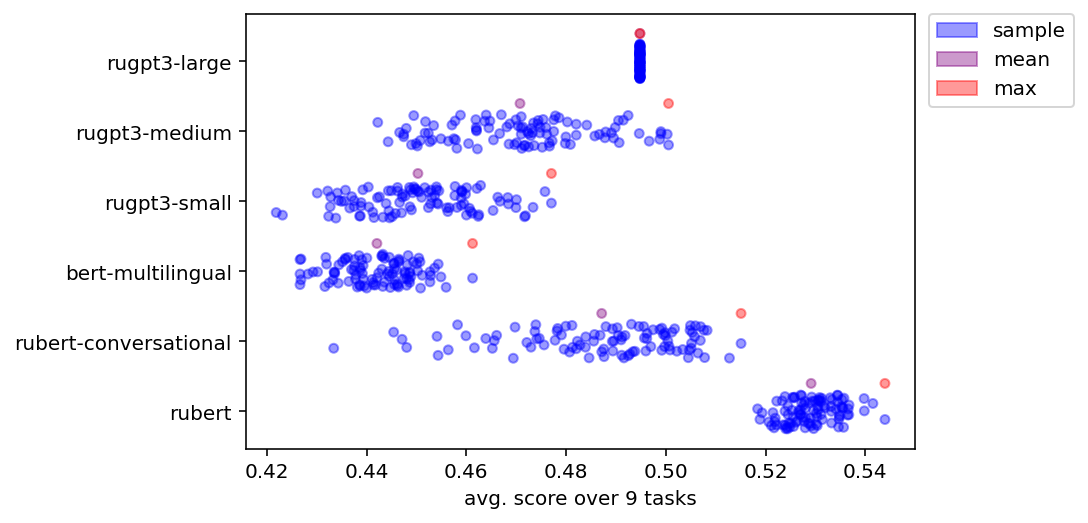

In [10]:
%run -n main
tasks = TASKS
# tasks = [DANETQA, MUSERC, RUCOS, RUSSE]
# show_seed_scores(leaderboard, grid_task_scores, tasks=tasks)
show_seed_scores2(grid_task_scores, tasks=tasks)

# bench

In [11]:
%run -n main
bench_registry = list(list_bench_registry(JIANT_BENCH_DIR))

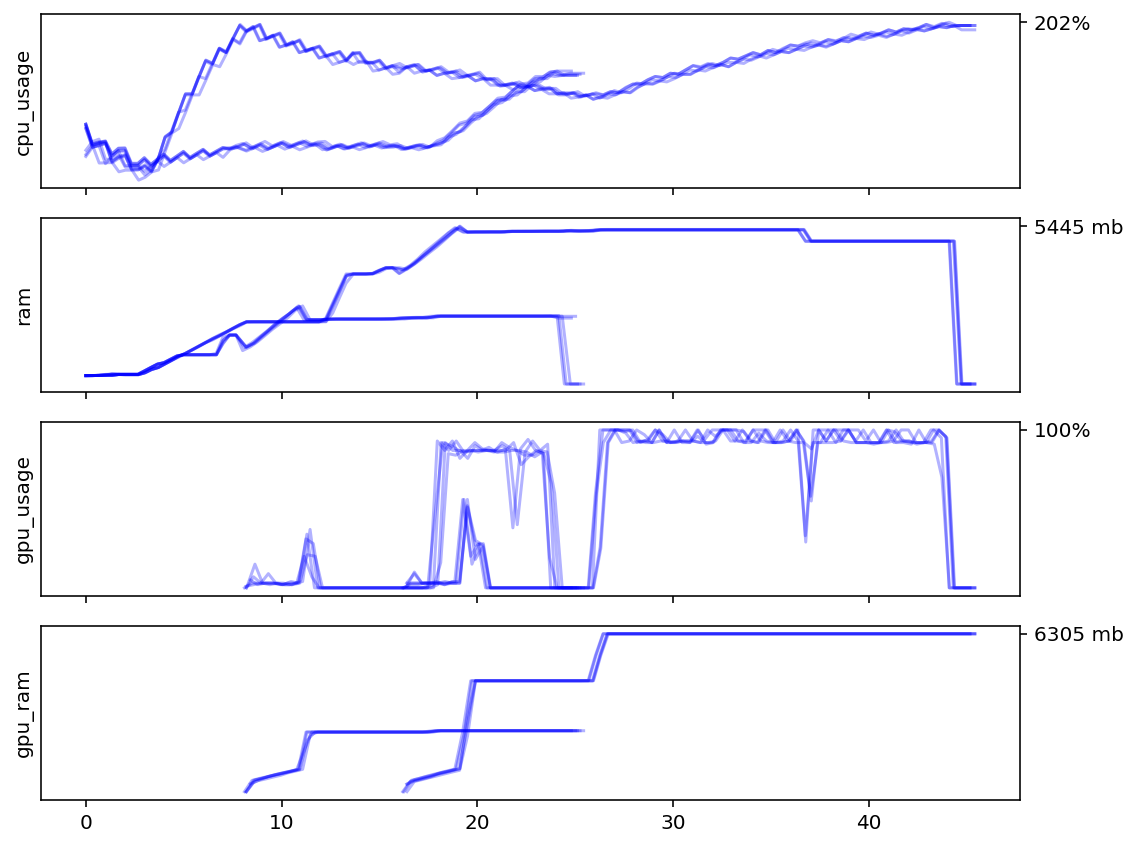

In [12]:
%run -n main
records = query_bench_registry(
    bench_registry,
    input_size=1,
    batch_size=1,
)

records = query_bench_registry(
    bench_registry,
    input_size=2000,
    batch_size=32,
    task=(TERRA),
    model=(RUBERT, RUGPT3_MEDIUM)
)

benches = [
    load_registry_bench(_)
    for _ in records
]

# task=(DANETQA, PARUS, RCB, RWSD, RUSSE, TERRA, LIDIRUS)
# task=(RUCOS, MUSERC)

# model=(RUBERT, RUBERT_CONVERSATIONAL, BERT_MULTILINGUAL)
# model=(RUGPT3_LARGE, RUGPT3_MEDIUM, RUGPT3_SMALL)

show_benches(benches)

## report

In [13]:
%run -n main
bench_groups = list(load_group_benches(bench_registry))

### gpu ram

In [14]:
%run -n main
show_gpu_ram_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
rubert-conversational,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
bert-multilingual,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4
rugpt3-small,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4,2.4 2.4 2.4 2.4 2.4
rugpt3-medium,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4,4.4 4.4 4.4 4.4 4.4
rugpt3-large,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5,7.5 7.5 7.5 7.5 7.5


In [15]:
%run -n main
table = show_gpu_ram_bench_report2(bench_groups)
table

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,2.40,2.40,2.39,2.39,2.40,2.39,2.39,2.39,2.39
rubert-conversational,2.40,2.40,2.39,2.39,2.40,2.39,2.39,2.39,2.39
bert-multilingual,2.40,2.40,2.39,2.39,2.40,2.39,2.40,2.39,2.39
rugpt3-small,2.38,2.38,2.36,2.37,2.38,2.36,2.36,2.37,2.36
rugpt3-medium,4.41,4.38,4.39,4.39,4.38,4.38,4.41,4.39,4.39
rugpt3-large,7.49,7.49,7.50,7.50,7.49,7.49,7.51,7.50,7.50


In [16]:
%run -n main
show_gpu_ram_hub_size_bench_report(bench_groups)

,gpu_ram,hub_size,ratio
rubert,2.39,0.66,3.61
rubert-conversational,2.39,0.66,3.61
bert-multilingual,2.39,0.67,3.59
rugpt3-small,2.37,0.51,4.61
rugpt3-medium,4.39,1.70,2.58
rugpt3-large,7.50,3.00,2.50


### time

In [17]:
%run -n main
show_init_time_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,18 18 18 18 27,18 18 20 27 36,18 18 19 26 28,18 19 19 26 26,19 19 19 19 27,18 18 18 26 27,18 18 19 19 27,18 18 18 27 28,18 18 18 18 18
rubert-conversational,18 18 18 35 35,18 18 19 27 27,18 18 18 27 27,18 18 18 27 27,18 18 19 27 27,18 18 18 26 26,18 18 19 27 27,18 18 19 26 27,18 18 18 18 18
bert-multilingual,18 19 19 36 37,19 19 19 20 79,18 18 19 27 27,18 18 19 27 27,19 19 19 27 28,18 18 19 27 27,18 18 19 26 27,19 19 19 27 27,18 18 18 19 19
rugpt3-small,19 19 19 19 33,19 20 20 20 27,19 19 19 19 28,19 19 19 19 28,20 20 20 20 26,19 19 19 19 28,19 20 20 20 28,19 19 19 19 28,19 19 19 19 20
rugpt3-medium,27 27 28 67 70,27 28 28 50 51,27 27 28 47 48,27 27 28 47 47,28 28 28 28 47,27 27 28 48 49,27 28 28 49 52,27 27 27 47 49,27 27 27 27 27
rugpt3-large,41 41 43 117 118,42 42 44 78 84,41 41 43 81 83,41 41 43 53 78,42 42 42 42 79,41 41 44 80 82,41 41 44 78 81,40 41 43 79 80,40 40 41 42 42


In [18]:
%run -n main
show_proc_time_bench_report(bench_groups)

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,17 17 17 17 17,454 456 456 456 457,2 2 2 2 2,6 7 7 7 7,223 223 224 224 224,9 9 9 9 9,19 19 20 20 20,6 7 7 7 7,11 11 12 13 13
rubert-conversational,19 19 19 19 20,459 460 461 462 465,3 3 3 3 3,7 7 7 7 7,234 234 235 236 237,9 9 9 9 9,19 20 20 20 20,6 7 7 7 7,12 12 12 12 12
bert-multilingual,22 22 22 22 22,492 493 495 496 497,4 4 4 4 5,10 10 10 10 10,297 298 298 299 300,12 12 12 12 12,23 23 24 24 24,10 10 10 10 11,15 15 15 15 15
rugpt3-small,21 21 21 21 54,463 465 465 468 477,2 2 2 2 11,7 7 7 7 16,259 259 260 261 261,12 12 12 13 21,19 19 19 19 28,6 6 6 6 15,11 11 11 11 11
rugpt3-medium,44 44 45 45 45,1127 1127 1128 1128 1128,7 7 7 7 8,19 20 20 20 20,604 605 605 605 605,19 19 19 19 19,29 29 29 29 29,18 18 18 18 18,19 19 19 19 19
rugpt3-large,74 75 75 75 78,528 933 1988 1992 1992,14 14 15 15 15,37 38 38 38 38,200 1055 1057 1059,12 26 27 27 27,40 40 41 41 41,33 33 33 33 33,29 29 29 29 29


In [19]:
%run -n main
table = show_rps_bench_report(bench_groups)
table

,danetqa,muserc,parus,rcb,rucos,russe,rwsd,terra,lidirus
rubert,118,4,1070,295,9,226,102,297,165
rubert-conversational,103,4,718,289,8,225,101,302,171
bert-multilingual,90,4,451,194,7,164,85,195,136
rugpt3-small,97,4,872,289,8,163,105,319,176
rugpt3-medium,45,2,270,102,3,106,70,111,106
rugpt3-large,27,1,137,53,2,75,49,61,69


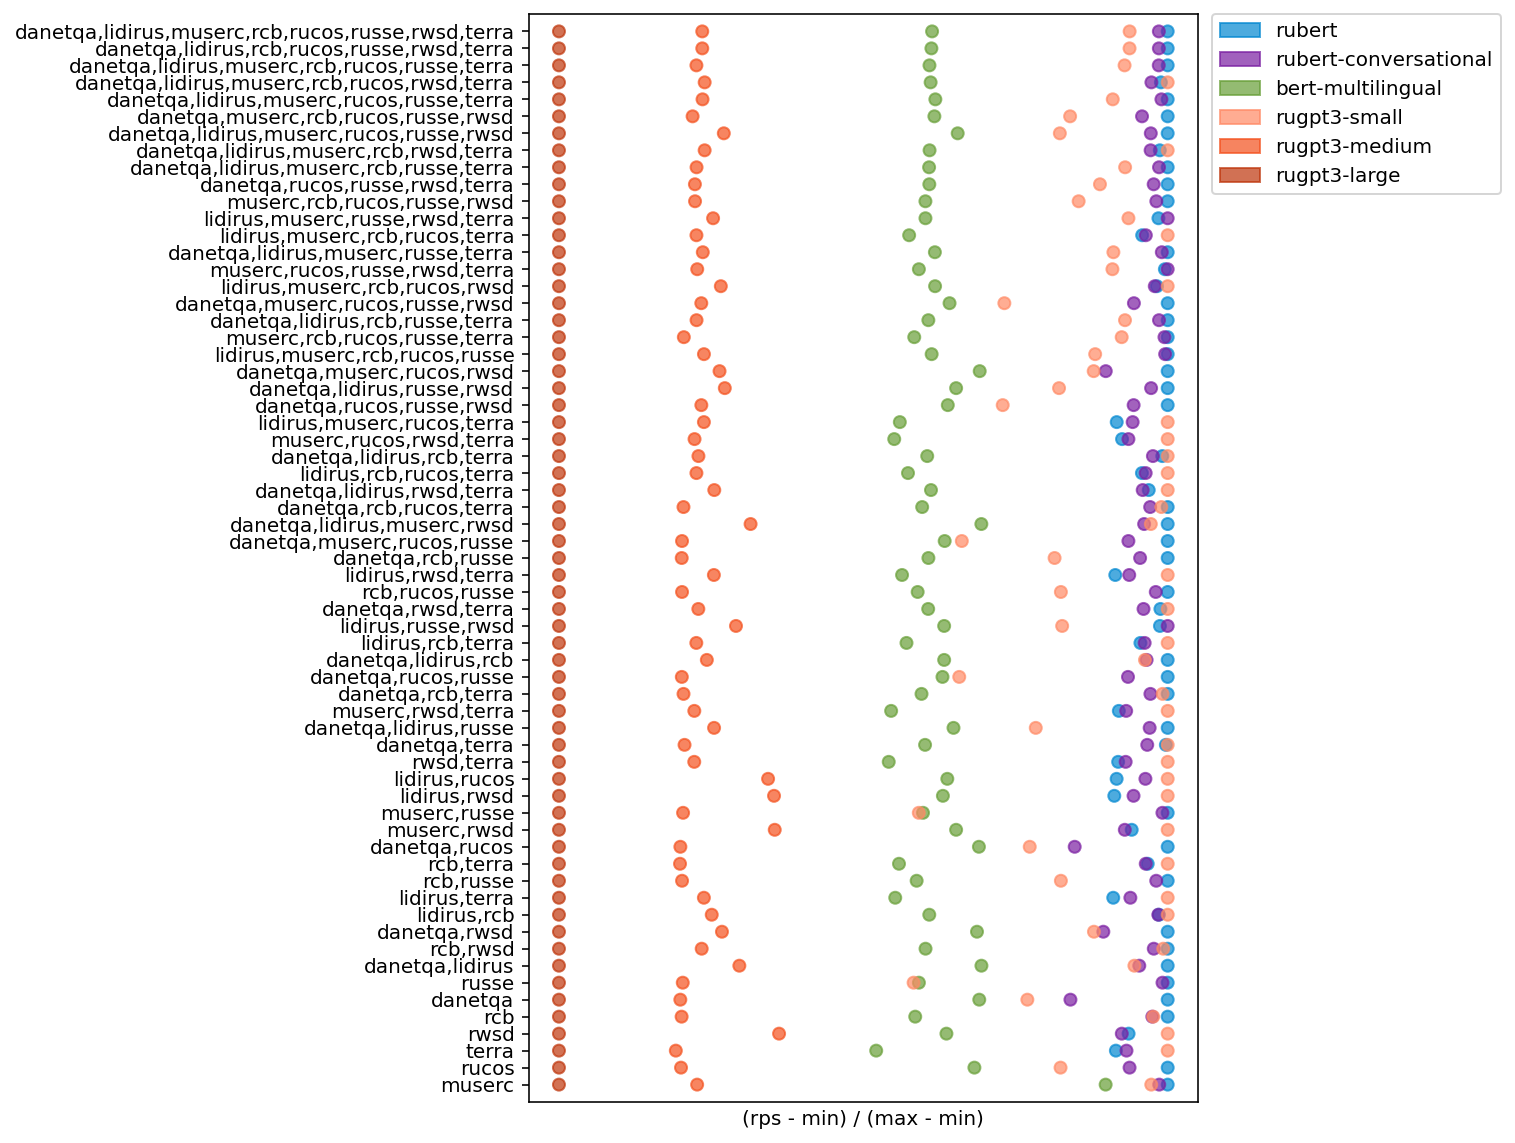

In [20]:
%run -n main
show_rps_order_bench_report(bench_groups)

## score perf

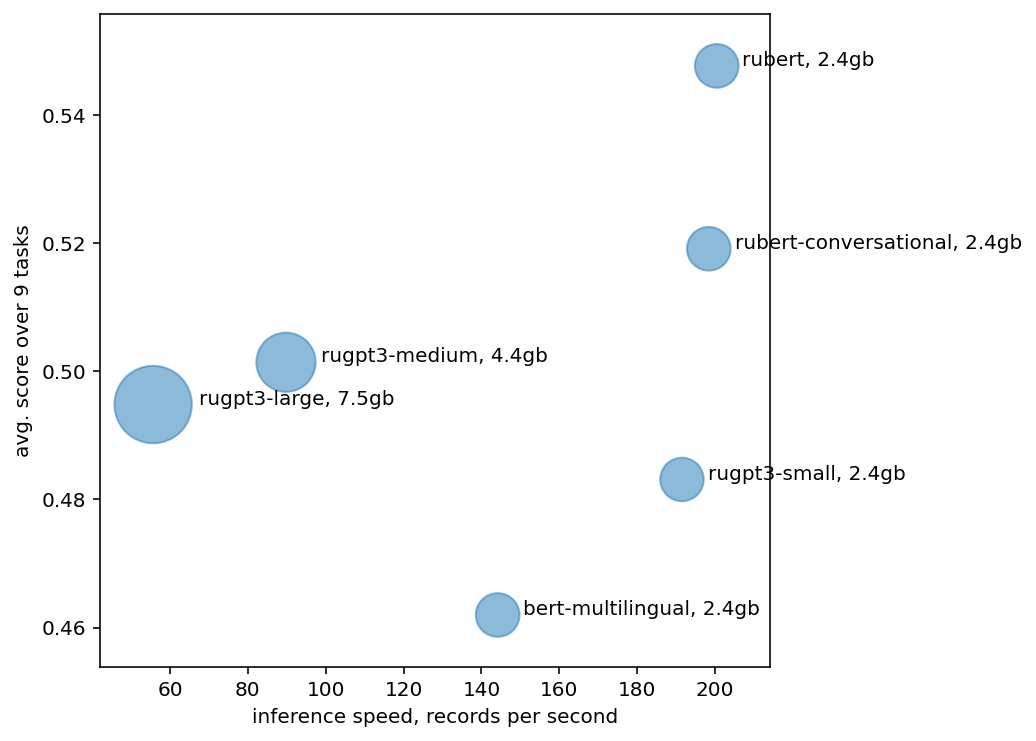

In [21]:
%run -n main
show_score_perf(jiant_task_scores, leaderboard, bench_groups)